In [35]:
# Import necessary libraries
import fitz  # PyMuPDF
import cv2
import numpy as np
import pandas as pd
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from openpyxl import Workbook

In [42]:
# Function to convert PDF pages to images
def pdf_to_images(pdf_path):
    print("Converting PDF to images...")
    pdf_document = fitz.open(pdf_path)
    images = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap(dpi=300)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(np.array(img))
        print(f"Extracted image from page {page_num + 1}")
    print("PDF conversion complete.\n")
    return images

In [43]:
# Class mapping
your_classes = {0: 'column_icon', 1: 'column_icon', 2: 'column_number', 3: 'column_length', 4: 'column_width'}

In [45]:
# Function to configure and load the Detectron2 model
def configure_detectron2():
    print("Configuring Detectron2 model...")
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Ensure this matches your model's trained classes
    cfg.MODEL.WEIGHTS = "C:\OCR\Output\model_final.pth"  # Path to your model file
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Detectron2 configuration complete.\n")
    return cfg, DefaultPredictor(cfg)

In [46]:
# Function to process images using Detectron2 model
def detect_objects(images, predictor, cfg):
    print("Detecting objects in images...")
    results = []
    for i, image in enumerate(images):
        outputs = predictor(image)
        print(f"Objects detected in image {i + 1}: {len(outputs['instances'])} instances found.")
        v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        # Display the detected objects
        plt.figure(figsize=(10, 10))
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.title(f"Detected objects in image {i + 1}")
        plt.axis('off')
        plt.show()
        
        results.append((out.get_image()[:, :, ::-1], outputs["instances"]))
    print("Object detection complete.\n")
    return results


Converting PDF to images...
Extracted image from page 1
PDF conversion complete.

Configuring Detectron2 model...
Detectron2 configuration complete.



C:\Users\malar\anaconda3\envs\OCR\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.de

Detecting objects in images...
Objects detected in image 1: 0 instances found.


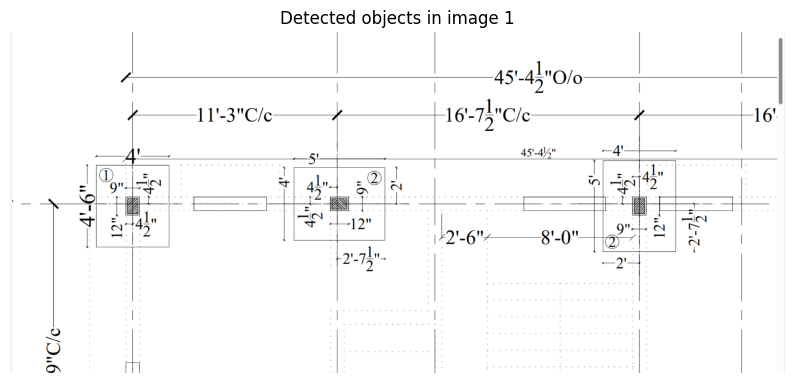

Object detection complete.

Processing detected objects in image 1...
Extracting dimensions from detected objects...
Extracted dimensions for 0 columns.

Exporting data to Excel...
Data successfully exported to column_data.xlsx

Process complete.


In [47]:
# Function to extract dimensions from detected objects
def extract_dimensions(instances, image):
    print("Extracting dimensions from detected objects...")
    columns_data = []
    for i in range(len(instances)):
        instance = instances[i]
        box = instance.pred_boxes.tensor.numpy()[0]
        column_width = box[2] - box[0]
        column_height = box[3] - box[1]
        columns_data.append({
            "Column Number": i + 1,
            "Column Length (meters)": column_height / 100,
            "Column Width (meters)": column_width / 100
        })
    print(f"Extracted dimensions for {len(columns_data)} columns.\n")
    return columns_data

# Function to export data to Excel
def export_to_excel(data, output_path):
    print("Exporting data to Excel...")
    df = pd.DataFrame(data)
    df.to_excel(output_path, index=False)
    print(f"Data successfully exported to {output_path}\n")

# Main function to execute the pipeline
def main(pdf_path, output_excel_path):
    images = pdf_to_images(pdf_path)
    cfg, predictor = configure_detectron2()
    detected_results = detect_objects(images, predictor, cfg)
    
    all_columns_data = []
    for img_idx, (visualized_image, instances) in enumerate(detected_results):
        print(f"Processing detected objects in image {img_idx + 1}...")
        columns_data = extract_dimensions(instances, images[img_idx])
        all_columns_data.extend(columns_data)
    
    export_to_excel(all_columns_data, output_excel_path)
    print("Process complete.")

# Execute the main function
if __name__ == "__main__":
    pdf_path = r"C:\OCR\Centerline_test.pdf"  # Specify the path to the PDF file
    output_excel_path = "column_data.xlsx"
    main(pdf_path, output_excel_path)

In [34]:
# Function to save results to Excel
def save_to_excel(detected_objects, output_path):
    data = {
        'Column Number': [],
        'Column Length': [],
        'Column Width': []
    }

    for obj in detected_objects:
        if obj['label'] == 'column_number':
            data['Column Number'].append(obj['text'])
        elif obj['label'] == 'column_length':
            data['Column Length'].append(obj['text'])
        elif obj['label'] == 'column_width':
            data['Column Width'].append(obj['text'])

    max_length = max(len(data['Column Number']), len(data['Column Length']), len(data['Column Width']))

    for key in data:
        data[key] += [None] * (max_length - len(data[key]))

    df = pd.DataFrame(data)
    df.to_excel(output_path, index=False)

# Main execution
model_path = "C:\OCR\Output\model_final.pth"  # Provide the correct path to your model
pdf_path = "C:\OCR\Centerline_test.pdf"  # Provide the path to your input PDF
output_excel_path = "output_columns_info.xlsx"

predictor = load_model("C:\OCR\Output\model_final.pth")
detected_objects = process_pdf(pdf_path, predictor)
save_to_excel(detected_objects, output_excel_path)

print(f"Columns information extracted and saved to {output_excel_path}")

C:\Users\malar\anaconda3\envs\OCR\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.de

Detected objects in page 0: []
Columns information extracted and saved to output_columns_info.xlsx
